In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

from torchsampler import ImbalancedDatasetSampler
import matplotlib as mpl
from tqdm import tqdm

torch.manual_seed(6)



In [2]:
train_dir = './train_images'
test_dir = './test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(degrees=(45, -45), fill=(0,)),
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2 
batch_size = 32 

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = ImbalancedDatasetSampler(train_data, train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data, valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        
        self.drop_out = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 2)
        
        self.softmax = nn.LogSoftmax(1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
n_epochs = 15
cv_folds = 1


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = None

criterion = nn.CrossEntropyLoss() # Loss function

for k in range(cv_folds):
    print(f"== Iteration {k} ==")
    time.sleep(0.5)
    
    net = Net().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.001) # Updates weights
    
    for epoch in range(1, n_epochs+1):
        train_loss_cumu, train_acc_cumu, train_total = 0, 0, 0
        
        # Training loop
        net.train()
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch} - Training \t: "):
            data, target=data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # Add to cumulated loss
            train_loss_cumu += loss.item()
            
            # Add to cumulated correct predictions
            _, predicted = torch.max(output.data, 1)
            train_acc_cumu += (predicted == target).sum().item() 
            train_total += target.size(0)
            
        train_loss = train_loss_cumu / len(train_loader)
        train_acc = train_acc_cumu / train_total
    
        valid_loss_cumu, valid_acc_cumu, valid_total = 0, 0, 0
        
        # Validation loop
        net.eval()
        for data, target in tqdm(valid_loader, desc=f"Epoch {epoch} - Validating \t: "):
            data, target=data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            
            # Add to cumulated loss
            valid_loss_cumu += loss.item()
            
            # Add to cumulated correct predictions
            _, predicted = torch.max(output.data, 1)
            valid_acc_cumu += (predicted == target).sum().item()
            valid_total += target.size(0)
            
        valid_loss = valid_loss_cumu / len(valid_loader)
        valid_acc = valid_acc_cumu / valid_total
        
        print(f"train_loss: {train_loss:.5f} \t train_acc: {train_acc * 100:.2f}%")
        print(f"valid_loss: {valid_loss:.5f} \t valid_acc: {valid_acc * 100:.2f}%")
        time.sleep(0.5)
    
    test_loss_cumu, test_acc_cumu, test_total = 0, 0, 0
    
    # Testing loop
    for data, target in tqdm(test_loader, desc=f"Testing : "):
        data, target=data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        
        # Add to cumulated loss
        test_loss_cumu += loss.item()
        
        # Add to cumulated correct predictions
        _, predicted = torch.max(output.data, 1)
        test_acc_cumu += (predicted == target).sum().item()
        test_total += target.size(0)

    test_loss = test_loss_cumu / len(test_loader)
    test_acc = test_acc_cumu / test_total
    print(f"test_loss: {test_loss:.5f} \t test_acc: {test_acc * 100:.2f}%")
    

== Iteration 0 ==


Epoch 1 - Validating 	: 100%|██████████| 2318/2318 [00:33<00:00, 69.02it/s]


train_loss: 0.22477 	 train_acc: 90.58%
valid_loss: 0.10785 	 valid_acc: 96.47%


Epoch 2 - Validating 	: 100%|██████████| 2318/2318 [00:41<00:00, 55.27it/s]


train_loss: 0.13229 	 train_acc: 95.05%
valid_loss: 0.10653 	 valid_acc: 96.03%


Epoch 3 - Validating 	: 100%|██████████| 2318/2318 [00:41<00:00, 55.30it/s]


train_loss: 0.10726 	 train_acc: 96.01%
valid_loss: 0.06358 	 valid_acc: 98.04%


Epoch 4 - Validating 	: 100%|██████████| 2318/2318 [00:42<00:00, 54.17it/s]


train_loss: 0.09557 	 train_acc: 96.55%
valid_loss: 0.05329 	 valid_acc: 98.32%


Epoch 5 - Validating 	: 100%|██████████| 2318/2318 [00:36<00:00, 63.52it/s]


train_loss: 0.08741 	 train_acc: 96.88%
valid_loss: 0.04952 	 valid_acc: 98.47%


Epoch 6 - Validating 	: 100%|██████████| 2318/2318 [00:39<00:00, 59.37it/s]


train_loss: 0.08104 	 train_acc: 97.02%
valid_loss: 0.05579 	 valid_acc: 98.32%


Epoch 7 - Validating 	: 100%|██████████| 2318/2318 [00:38<00:00, 59.68it/s]


train_loss: 0.07651 	 train_acc: 97.21%
valid_loss: 0.04434 	 valid_acc: 98.59%


Epoch 8 - Validating 	: 100%|██████████| 2318/2318 [00:37<00:00, 61.08it/s]


train_loss: 0.07428 	 train_acc: 97.37%
valid_loss: 0.04418 	 valid_acc: 98.53%


Epoch 9 - Validating 	: 100%|██████████| 2318/2318 [00:35<00:00, 65.54it/s]


train_loss: 0.07107 	 train_acc: 97.47%
valid_loss: 0.05575 	 valid_acc: 98.28%


Epoch 10 - Validating 	: 100%|██████████| 2318/2318 [00:33<00:00, 68.85it/s]


train_loss: 0.06792 	 train_acc: 97.58%
valid_loss: 0.05404 	 valid_acc: 98.11%


Epoch 11 - Validating 	: 100%|██████████| 2318/2318 [00:38<00:00, 60.89it/s]


train_loss: 0.06797 	 train_acc: 97.60%
valid_loss: 0.04244 	 valid_acc: 98.69%


Epoch 12 - Validating 	: 100%|██████████| 2318/2318 [00:32<00:00, 70.81it/s]


train_loss: 0.06454 	 train_acc: 97.70%
valid_loss: 0.05376 	 valid_acc: 98.04%


Epoch 13 - Validating 	: 100%|██████████| 2318/2318 [00:36<00:00, 63.94it/s]


train_loss: 0.06207 	 train_acc: 97.80%
valid_loss: 0.04300 	 valid_acc: 98.68%


Epoch 14 - Validating 	: 100%|██████████| 2318/2318 [00:42<00:00, 55.10it/s]


train_loss: 0.06234 	 train_acc: 97.75%
valid_loss: 0.03782 	 valid_acc: 98.81%


Epoch 15 - Validating 	: 100%|██████████| 2318/2318 [00:43<00:00, 53.29it/s]


train_loss: 0.06280 	 train_acc: 97.79%
valid_loss: 0.03844 	 valid_acc: 98.89%


Testing : 100%|██████████| 239/239 [00:58<00:00,  4.08it/s]

test_loss: 0.05296 	 test_acc: 98.35%


In [8]:
PATH = './modelT_net.pth'
torch.save(net.state_dict(), PATH)

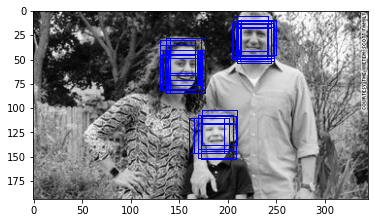

In [14]:
from PIL import Image

model = Net()
model.load_state_dict(torch.load(PATH))

img_path = './family_reunion_2_small.jpg'
image = Image.open(img_path)

transform2 = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

plt.imshow(transform2(image)[0], cmap=plt.get_cmap("gray"))
ax = plt.gca()
    
length = image.size[0]
height = image.size[1]

detected_faces = list()
incrementation = 4
incr = 0.1
window_step = 4

for zoom in range (incrementation):
    f = 1 - zoom*incr
    
    new_length = int(length*f)
    new_height = int(height*f)
    new_image = image.resize((new_length, new_height))
    new_tensor = transform2(new_image)
    
    for x in range(0, new_length - 36, window_step):
        for y in range(0, new_height - 36, window_step):
            new_window = new_tensor[:, y:y+36, x:x+36]
            new_window = new_window.unsqueeze(0)
            outputs = model(new_window)
            
            _, face_recognition = outputs.data.tolist()[0]
            if (face_recognition > 4):
                detected_faces.append([x/f, y/f])
            
    
    for face in detected_faces:
        x, y = face
        rect = mpl.patches.Rectangle((x, y), 36, 36, color='b', fill=False)
        ax.add_patch(rect)
                